In [1]:
%matplotlib inline
import pandas as pd
import os
import numpy as np
import math
import csv
import pickle
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
import seaborn as sns
from pylab import rcParams
import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from Model import AccExtractor, AccClassifier
from matplotlib.lines import Line2D   
from tqdm import tqdm
import tqdm
    
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8

from scipy.interpolate import make_interp_spline, BSpline


In [2]:
home_url = os.getcwd()
url = home_url + "/Dataset/"

save_path = home_url + "/Preprocessed Dataset/"
pth_path = home_url + "/Saved Model/"
figure_save_path = home_url + "/Saved Image/"

feature_save_path = pth_path+ "extractor.pth"
classifier_save_path = pth_path + "classifier.pth"

file_name = ['P1','P2','P3','P4']
item = ["train","valid", "test"]

train_percentage = 0.6
valid_percentage = 0.2

beta1=0.9
beta2=0.999
epoch = 500
learning_rate = 0.0005
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

batch_size = 16
overlap = 0.60
win_size=64

first_channel = 64
sec_channel = 128
first_dim = 9
sec_dim =5
out_dim = 32

step_size=int(win_size*overlap)
AXIS = 3
FROM = 0
TO = FROM+3
START = 4
END = 5

In [3]:
train_dataset = []
train_gt_dataset = []
valid_dataset = []
valid_gt_dataset = []
test_dataset = []
test_gt_dataset = []

In [4]:
def A_plot():
    figure_name = "Batch-"+str(batch_size)+"-Overlap-"+str(overlap)+"-win_size-"+str(win_size)+"-first_channel-"+\
        str(first_channel)+"-sec_channel-"+str(sec_channel)+"-first_dim-"+str(first_dim)+"-sec_dim-"+str(sec_dim)+\
        "--out_dim"+str(out_dim)
        
    data = np.loadtxt('result.csv', delimiter=',')
    

    plt.plot(range(1, len(data[:, 0]) + 1), data[:, 0], color='darkorange', label='train')
    plt.plot(range(1, len(data[:, 1]) + 1), data[:, 1], color='maroon', label='validation')
    plt.legend()
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Accuracy (%)', fontsize=14)
    plt.ylim(0, 100)
    
    ax = plt.axes()
    ax.set_facecolor('whitesmoke')
    
    fig = plt.figure()
    fig.savefig(figure_save_path+figure_name+'.png')

In [5]:
for user in range(4):
    for split_index in range(0,3):
        file = file_name[user] +'_'+item[split_index]

        print(file)
        df = pd.read_csv(save_path+file+'.csv', sep=",")   
        len_df = df.shape[0]
        narray = df.values

        for i in range(0, len_df, step_size):
            window = narray[i:i+win_size, FROM:TO]

            if window.shape[0] != win_size:
                continue
            else:
                reshaped_window = window.reshape(1,win_size,1,AXIS)
                gt = np.bincount(narray[i:i+win_size,START:END].astype(int).ravel()).argmax()

                if split_index == 0:
                    train_dataset.append(reshaped_window)
                    train_gt_dataset.append(gt)
                elif split_index == 1:
                    valid_dataset.append(reshaped_window)
                    valid_gt_dataset.append(gt)
                elif split_index == 2:
                    test_dataset.append(reshaped_window)
                    test_gt_dataset.append(gt)

P1_train
P1_valid
P1_test
P2_train
P2_valid
P2_test
P3_train
P3_valid
P3_test
P4_train
P4_valid
P4_test


### Data Structure

In [6]:
output_gt_number = len(np.unique(train_gt_dataset))
output_gt_number

6

In [7]:
train_penalty = np.concatenate( train_dataset, axis=0 )
train_gt = np.array(train_gt_dataset  )
valid_penalty = np.concatenate( valid_dataset, axis=0 )
valid_gt = np.array(valid_gt_dataset  )
test_penalty = np.concatenate( test_dataset, axis=0 )
test_gt = np.array(test_gt_dataset  )

In [8]:
train_penalty.shape

(382, 64, 1, 3)

In [9]:
valid_penalty.shape

(105, 64, 1, 3)

In [10]:
train_gt =train_gt.astype(np.float32)
valid_gt =valid_gt.astype(np.float32)
test_gt =test_gt.astype(np.float32)

train_penalty =train_penalty.astype(np.float32)
valid_penalty =valid_penalty.astype(np.float32)
test_penalty =test_penalty.astype(np.float32)

In [11]:
train_penalty.shape

(382, 64, 1, 3)

### Data loader Class

In [12]:
class data_loader():
    def __init__(self, samples, labels, transform=None):
        self.samples = samples
        self.labels = labels
        self.transform = transform

    def __getitem__(self, index):
        return self.samples[index], self.labels[index]

    def __len__(self):
        return len(self.samples)

In [13]:
def load(train_x, train_y, test_x, test_y, batch_size=64):
    
    train_x_swap = np.swapaxes(train_x,1,3)
    test_x_swap = np.swapaxes(test_x,1,3)

    train_set = data_loader(train_x_swap, train_y)
    test_set = data_loader(test_x_swap, test_y)
    
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)
    return train_loader, test_loader

In [14]:
def test_load(test_x, test_y, batch_size=64):
    
    test_x_swap = np.swapaxes(test_x,1,3)
    test_set = data_loader(test_x_swap, test_y)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
    return test_loader

### Train Model

In [15]:
result = []
def train(extractor, optimizer, train, test):
    n_batch = len(train.dataset) // batch_size
    print(n_batch)
    criterion = nn.CrossEntropyLoss()

    for e in range(epoch):
        
        extractor.train()
        
        correct = 0
        total = 0
        loss = 0               
        
        for index, (sample, target) in enumerate(train):

            sample, target = sample.to(device).float(), target.to(device).long()        
            sample = sample.view(-1, AXIS, 1, win_size)     
            
            output = extractor(sample)
            loss = criterion(output, target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss += loss.item()
            
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum()
            
        acc_train = float(correct) * 100/ total
        tqdm.tqdm.write('Epoch: [{}/{}], A acc: {:.2f}%'.format(e + 1, epoch, acc_train))

        # Testing
        extractor.eval()
        
        with torch.no_grad():
            correct = 0
            total = 0
            
            for sample, target in test:
          
                sample, target = sample.to(device).float(), target.to(device).long()
                sample = sample.view(-1, AXIS, 1, win_size)     
                output = extractor(sample)
                
                _, predicted = torch.max(output.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum()
    
        acc_test = float(correct) * 100/ total
        tqdm.tqdm.write('Epoch: [{}/{}], A Valid Acc: {:.2f}%'.format(e + 1, epoch, acc_test))
        
        result.append([acc_train, acc_test]) 
        result_np = np.array(result, dtype=float)
        
        np.savetxt('result.csv', result_np, fmt='%.2f', delimiter=',')
        
        torch.save(extractor.state_dict(),feature_save_path)

### Execute the model

23
Epoch: [1/500], A acc: 16.03%
Epoch: [1/500], A Valid Acc: 14.29%
Epoch: [2/500], A acc: 13.59%
Epoch: [2/500], A Valid Acc: 20.00%
Epoch: [3/500], A acc: 16.30%
Epoch: [3/500], A Valid Acc: 22.86%
Epoch: [4/500], A acc: 21.74%
Epoch: [4/500], A Valid Acc: 22.86%
Epoch: [5/500], A acc: 18.75%
Epoch: [5/500], A Valid Acc: 22.86%
Epoch: [6/500], A acc: 24.46%
Epoch: [6/500], A Valid Acc: 22.86%
Epoch: [7/500], A acc: 19.02%
Epoch: [7/500], A Valid Acc: 22.86%
Epoch: [8/500], A acc: 20.11%
Epoch: [8/500], A Valid Acc: 22.86%
Epoch: [9/500], A acc: 18.21%
Epoch: [9/500], A Valid Acc: 24.76%
Epoch: [10/500], A acc: 19.29%
Epoch: [10/500], A Valid Acc: 23.81%
Epoch: [11/500], A acc: 19.57%
Epoch: [11/500], A Valid Acc: 26.67%
Epoch: [12/500], A acc: 20.11%
Epoch: [12/500], A Valid Acc: 29.52%
Epoch: [13/500], A acc: 16.85%
Epoch: [13/500], A Valid Acc: 26.67%
Epoch: [14/500], A acc: 20.92%
Epoch: [14/500], A Valid Acc: 22.86%
Epoch: [15/500], A acc: 20.92%
Epoch: [15/500], A Valid Acc: 24

Epoch: [122/500], A acc: 55.98%
Epoch: [122/500], A Valid Acc: 52.38%
Epoch: [123/500], A acc: 56.25%
Epoch: [123/500], A Valid Acc: 52.38%
Epoch: [124/500], A acc: 58.42%
Epoch: [124/500], A Valid Acc: 47.62%
Epoch: [125/500], A acc: 58.70%
Epoch: [125/500], A Valid Acc: 49.52%
Epoch: [126/500], A acc: 52.45%
Epoch: [126/500], A Valid Acc: 47.62%
Epoch: [127/500], A acc: 58.70%
Epoch: [127/500], A Valid Acc: 52.38%
Epoch: [128/500], A acc: 57.88%
Epoch: [128/500], A Valid Acc: 51.43%
Epoch: [129/500], A acc: 58.15%
Epoch: [129/500], A Valid Acc: 52.38%
Epoch: [130/500], A acc: 58.97%
Epoch: [130/500], A Valid Acc: 49.52%
Epoch: [131/500], A acc: 60.05%
Epoch: [131/500], A Valid Acc: 49.52%
Epoch: [132/500], A acc: 60.05%
Epoch: [132/500], A Valid Acc: 47.62%
Epoch: [133/500], A acc: 60.05%
Epoch: [133/500], A Valid Acc: 52.38%
Epoch: [134/500], A acc: 59.51%
Epoch: [134/500], A Valid Acc: 51.43%
Epoch: [135/500], A acc: 63.59%
Epoch: [135/500], A Valid Acc: 52.38%
Epoch: [136/500], A 

Epoch: [241/500], A acc: 69.57%
Epoch: [241/500], A Valid Acc: 54.29%
Epoch: [242/500], A acc: 69.84%
Epoch: [242/500], A Valid Acc: 46.67%
Epoch: [243/500], A acc: 69.29%
Epoch: [243/500], A Valid Acc: 48.57%
Epoch: [244/500], A acc: 68.75%
Epoch: [244/500], A Valid Acc: 51.43%
Epoch: [245/500], A acc: 70.11%
Epoch: [245/500], A Valid Acc: 47.62%
Epoch: [246/500], A acc: 69.57%
Epoch: [246/500], A Valid Acc: 47.62%
Epoch: [247/500], A acc: 71.74%
Epoch: [247/500], A Valid Acc: 52.38%
Epoch: [248/500], A acc: 72.28%
Epoch: [248/500], A Valid Acc: 54.29%
Epoch: [249/500], A acc: 69.84%
Epoch: [249/500], A Valid Acc: 52.38%
Epoch: [250/500], A acc: 70.11%
Epoch: [250/500], A Valid Acc: 52.38%
Epoch: [251/500], A acc: 70.65%
Epoch: [251/500], A Valid Acc: 48.57%
Epoch: [252/500], A acc: 70.11%
Epoch: [252/500], A Valid Acc: 49.52%
Epoch: [253/500], A acc: 68.75%
Epoch: [253/500], A Valid Acc: 52.38%
Epoch: [254/500], A acc: 76.90%
Epoch: [254/500], A Valid Acc: 49.52%
Epoch: [255/500], A 

Epoch: [360/500], A acc: 70.65%
Epoch: [360/500], A Valid Acc: 46.67%
Epoch: [361/500], A acc: 73.64%
Epoch: [361/500], A Valid Acc: 49.52%
Epoch: [362/500], A acc: 73.64%
Epoch: [362/500], A Valid Acc: 49.52%
Epoch: [363/500], A acc: 73.10%
Epoch: [363/500], A Valid Acc: 44.76%
Epoch: [364/500], A acc: 73.10%
Epoch: [364/500], A Valid Acc: 48.57%
Epoch: [365/500], A acc: 76.63%
Epoch: [365/500], A Valid Acc: 54.29%
Epoch: [366/500], A acc: 72.55%
Epoch: [366/500], A Valid Acc: 52.38%
Epoch: [367/500], A acc: 72.55%
Epoch: [367/500], A Valid Acc: 50.48%
Epoch: [368/500], A acc: 76.36%
Epoch: [368/500], A Valid Acc: 50.48%
Epoch: [369/500], A acc: 73.37%
Epoch: [369/500], A Valid Acc: 51.43%
Epoch: [370/500], A acc: 71.47%
Epoch: [370/500], A Valid Acc: 50.48%
Epoch: [371/500], A acc: 71.47%
Epoch: [371/500], A Valid Acc: 52.38%
Epoch: [372/500], A acc: 72.28%
Epoch: [372/500], A Valid Acc: 50.48%
Epoch: [373/500], A acc: 75.82%
Epoch: [373/500], A Valid Acc: 44.76%
Epoch: [374/500], A 

Epoch: [478/500], A acc: 74.73%
Epoch: [478/500], A Valid Acc: 46.67%
Epoch: [479/500], A acc: 77.17%
Epoch: [479/500], A Valid Acc: 46.67%
Epoch: [480/500], A acc: 78.80%
Epoch: [480/500], A Valid Acc: 46.67%
Epoch: [481/500], A acc: 76.09%
Epoch: [481/500], A Valid Acc: 50.48%
Epoch: [482/500], A acc: 72.28%
Epoch: [482/500], A Valid Acc: 50.48%
Epoch: [483/500], A acc: 73.37%
Epoch: [483/500], A Valid Acc: 48.57%
Epoch: [484/500], A acc: 77.99%
Epoch: [484/500], A Valid Acc: 50.48%
Epoch: [485/500], A acc: 75.27%
Epoch: [485/500], A Valid Acc: 49.52%
Epoch: [486/500], A acc: 78.26%
Epoch: [486/500], A Valid Acc: 50.48%
Epoch: [487/500], A acc: 77.45%
Epoch: [487/500], A Valid Acc: 49.52%
Epoch: [488/500], A acc: 77.17%
Epoch: [488/500], A Valid Acc: 54.29%
Epoch: [489/500], A acc: 74.73%
Epoch: [489/500], A Valid Acc: 53.33%
Epoch: [490/500], A acc: 78.80%
Epoch: [490/500], A Valid Acc: 47.62%
Epoch: [491/500], A acc: 74.73%
Epoch: [491/500], A Valid Acc: 48.57%
Epoch: [492/500], A 

/home/avijoy/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


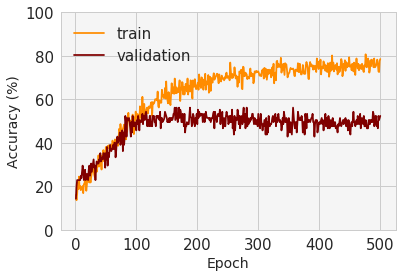

<Figure size 432x288 with 0 Axes>

In [16]:
if __name__ == '__main__':
    torch.manual_seed(10)
    
    train_data, valid_data = load(train_penalty, train_gt, valid_penalty, valid_gt, batch_size)
    
    extractor = AccExtractor(win_size, first_channel, sec_channel, first_dim, sec_dim, out_dim, output_gt_number).to(device)
    param_list = list(extractor.parameters())
    optimizer = optim.Adam(params=param_list, lr=learning_rate, betas=(beta1, beta2), weight_decay=1e-5)
    train(extractor, optimizer, train_data, valid_data)
    
    A_plot()

### Evaluate on Test Dataset

In [17]:
extractor = AccExtractor(win_size, first_channel, sec_channel, first_dim, sec_dim, out_dim, output_gt_number).to(device)
extractor.load_state_dict(torch.load(feature_save_path))

extractor.eval()

print("Evaluating...")
target_loader = test_load(test_penalty, test_gt, batch_size=64)


correct = 0
total = 0

accuracy = []
for t_sample, t_target in target_loader:

    t_sample, t_target = t_sample.to(device).float(), t_target.to(device).long()
    t_sample = t_sample.view(-1, AXIS, 1, win_size)
    output = extractor(t_sample)

    _, predicted = torch.max(output.data, 1)
    total += t_target.size(0)
    correct += (predicted == t_target).sum()

acc_test = float(correct) * 100 / total
tqdm.tqdm.write('Test Acc: {:.2f}%'.format(acc_test))

Evaluating...
Test Acc: 48.70%
